In [68]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torchviz import make_dot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import datetime

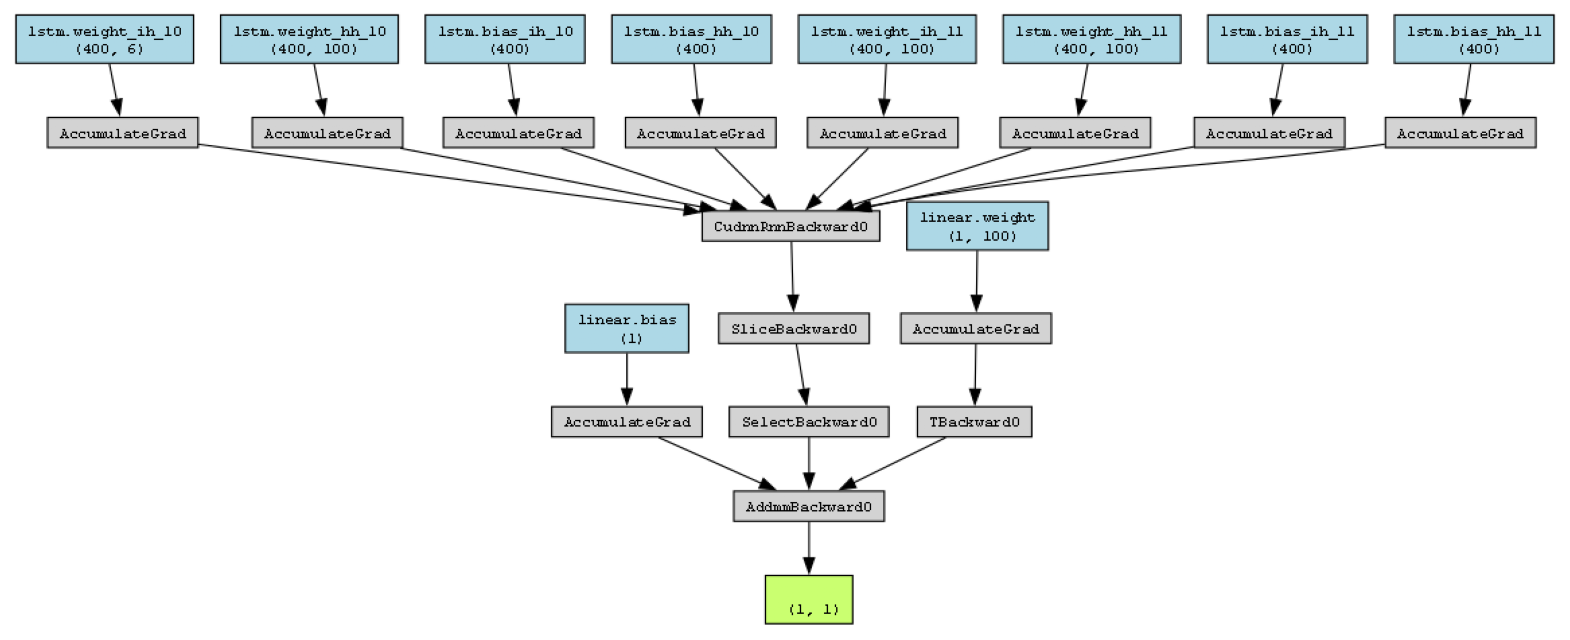

In [51]:
# Assuming your model and a sample input
model = LSTMModel(input_size, hidden_layer_size, output_size).to(device)
sample_input = torch.zeros((1, time_steps, input_size), device=device)  # Adjust the shape according to your input
out = model(sample_input)

# Visualize the model
dot = make_dot(out, params=dict(model.named_parameters()))

# Render the graph to a file temporarily
dot.format = 'png'
path = dot.render(filename='inline_graph', directory='/tmp', cleanup=True)

# Load the image and adjust the figure size
img = plt.imread(path)
plt.figure(figsize=(20, 20))  # You can adjust these dimensions as needed
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()


In [52]:
# Load data from CSV files
btc_data_daily = pd.read_csv('btc_data_daily.csv', index_col='time', parse_dates=True)

# Filter numeric columns only
numeric_cols = ['close', 'high', 'low', 'open', 'volumefrom', 'volumeto']
btc_data_daily = btc_data_daily[numeric_cols]

# Handle missing values by forward filling
btc_data_daily.fillna(method='ffill', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
btc_data_daily_scaled = scaler.fit_transform(btc_data_daily)
btc_data_daily_scaled = pd.DataFrame(btc_data_daily_scaled, columns=btc_data_daily.columns, index=btc_data_daily.index)

# Define the LSTM model with more layers and units
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(2, 1, self.hidden_layer_size).to(device),
                            torch.zeros(2, 1, self.hidden_layer_size).to(device))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        predictions = self.linear(lstm_out[:, -1])
        return predictions

# Prepare data for training
def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps, 0])  # Extract only the closing price for the target
    return torch.tensor(X, dtype=torch.float32).to(device), torch.tensor(y, dtype=torch.float32).unsqueeze(1).to(device)

# Check for CUDA availability and set the device
if torch.cuda.is_available():
    device = torch.device('cuda:0')  # Change 'cuda:0' to your specific GPU if necessary
    torch.cuda.set_device(device)
    print(f'Using GPU: {torch.cuda.get_device_name(0)}')
else:
    device = torch.device('cpu')
    print('No GPU available, using the CPU instead.')

# Example with daily data
time_steps = 60  # Use last 60 days for prediction
X_daily, y_daily = prepare_data(btc_data_daily_scaled.values, time_steps)

# Create the model
input_size = X_daily.shape[2]
hidden_layer_size = 100  # Increase hidden units
output_size = 1
model = LSTMModel(input_size, hidden_layer_size, output_size).to(device)

# Define loss and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # Lower learning rate

for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_mape = 0
    
    # Initialize hidden state at the start of each epoch
    model.hidden_cell = (torch.zeros(2, 1, model.hidden_layer_size, device=device),
                         torch.zeros(2, 1, model.hidden_layer_size, device=device))

    for i in range(len(X_daily)):
        optimizer.zero_grad()
        
        # Forward pass
        model.hidden_cell = (model.hidden_cell[0].detach(), model.hidden_cell[1].detach())  # Detach hidden state
        y_pred = model(X_daily[i].unsqueeze(0))
        y_target = y_daily[i].view_as(y_pred)  # Match the shape of y_pred
        
        # Compute loss
        single_loss = loss_function(y_pred, y_target)
        single_loss.backward(retain_graph=True)  # You might not need this if you're detaching correctly
        optimizer.step()

        total_loss += single_loss.item()
        total_mape += (torch.mean(torch.abs((y_target - y_pred) / y_target)) * 100).item()

    avg_loss = total_loss / len(X_daily)
    avg_mape = total_mape / len(X_daily)
    print(f'Epoch {epoch+1} Loss: {avg_loss:.4f}, MAPE: {avg_mape:.4f}%')

# Save the model
torch.save(model.state_dict(), 'btc_trading_model.pth')


C:\Users\Aaron\AppData\Local\Temp\ipykernel_19972\1161815406.py:9: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Using GPU: NVIDIA GeForce RTX 3060
Epoch 1 Loss: 0.0016, MAPE: 9.4999%
Epoch 2 Loss: 0.0035, MAPE: 27.0738%
Epoch 3 Loss: 0.0028, MAPE: 24.4345%
Epoch 4 Loss: 0.0019, MAPE: 18.1249%
Epoch 5 Loss: 0.0013, MAPE: 13.4963%
Epoch 6 Loss: 0.0011, MAPE: 11.9462%
Epoch 7 Loss: 0.0011, MAPE: 10.7684%
Epoch 8 Loss: 0.0010, MAPE: 10.0744%
Epoch 9 Loss: 0.0010, MAPE: 10.3699%
Epoch 10 Loss: 0.0009, MAPE: 9.5711%
Epoch 11 Loss: 0.0008, MAPE: 8.7646%
Epoch 12 Loss: 0.0007, MAPE: 7.9173%
Epoch 13 Loss: 0.0007, MAPE: 7.0630%
Epoch 14 Loss: 0.0006, MAPE: 6.0162%
Epoch 15 Loss: 0.0006, MAPE: 6.1245%
Epoch 16 Loss: 0.0006, MAPE: 7.1824%
Epoch 17 Loss: 0.0006, MAPE: 5.5996%
Epoch 18 Loss: 0.0006, MAPE: 7.0413%
Epoch 19 Loss: 0.0005, MAPE: 5.6478%
Epoch 20 Loss: 0.0005, MAPE: 6.6283%
Epoch 21 Loss: 0.0005, MAPE: 5.3771%
Epoch 22 Loss: 0.0005, MAPE: 6.3772%
Epoch 23 Loss: 0.0005, MAPE: 4.8101%
Epoch 24 Loss: 0.0007, MAPE: 9.8653%
Epoch 25 Loss: 0.0007, MAPE: 8.6778%
Epoch 26 Loss: 0.0005, MAPE: 6.6291%
Epoc

In [67]:
# Assuming the model has been trained and saved
model.load_state_dict(torch.load('btc_trading_model.pth'))
model.eval()

# Prepare test data
def prepare_test_data(data, time_steps):
    X = []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
    return torch.tensor(X, dtype=torch.float32).to(device)

# Split the data into train and test sets
train_size = int(len(btc_data_daily_scaled) * 0.8)
test_data = btc_data_daily_scaled.values[train_size - time_steps:]

X_test = prepare_test_data(test_data, time_steps)

# Get predictions
model.hidden_cell = (torch.zeros(2, 1, model.hidden_layer_size, device=device),
                     torch.zeros(2, 1, model.hidden_layer_size, device=device))

predicted_prices = []

for i in range(len(X_test)):
    with torch.no_grad():
        pred = model(X_test[i].unsqueeze(0)).cpu().item()
        predicted_prices.append(pred)

# Convert predicted_prices to numpy array
predicted_prices = np.array(predicted_prices).reshape(-1, 1)

# Rescale predicted prices using the scaler fitted on the 'close' prices
close_scaler = MinMaxScaler()
close_scaler.fit(btc_data_daily[['close']])  # Fit on the 'close' column data
predicted_prices_rescaled = close_scaler.inverse_transform(predicted_prices)

# Combine predicted prices with actual test prices for plotting
actual_prices = btc_data_daily.iloc[train_size:].copy()  # Test set portion
actual_prices['Predicted'] = np.nan
actual_prices['Predicted'][-len(predicted_prices_rescaled):] = predicted_prices_rescaled.flatten()

# Plot the results using Plotly dark theme
fig = go.Figure()

# Add actual prices trace
fig.add_trace(go.Scatter(x=actual_prices.index, y=actual_prices['close'], mode='lines', name='Actual Price', line=dict(color='royalblue')))

# Add predicted prices trace
fig.add_trace(go.Scatter(x=actual_prices.index[-len(predicted_prices_rescaled):], y=actual_prices['Predicted'], mode='lines', name='Predicted Price', line=dict(color='orange', dash='dash')))

# Update layout for dark theme
fig.update_layout(
    title='BTC Price Prediction vs Actual',
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    template='plotly_dark',
    legend=dict(x=0, y=1, traceorder='normal'),
    hovermode='x unified'
)

fig.show()

C:\Users\Aaron\AppData\Local\Temp\ipykernel_19972\951824504.py:2: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

C:\Users\Aaron\AppData\Local\Temp\ipykernel_19972\951824504.p

In [75]:
# Number of days to predict into the future
future_days = 10

# Get the last `time_steps` data points from the scaled dataset
last_data = btc_data_daily_scaled.values[-time_steps:]

# Initialize list to store future predictions
future_predictions = []

# Loop to predict each future day iteratively
for _ in range(future_days):
    # Prepare the input (reshape for the model)
    input_data = torch.tensor(last_data[-time_steps:], dtype=torch.float32).unsqueeze(0).to(device)
    
    # Predict the next day's closing price
    with torch.no_grad():
        pred = model(input_data).cpu().item()
    
    # Store the predicted value
    future_predictions.append(pred)
    
    # Update `last_data` to include the new prediction
    new_data_point = np.append(last_data[1:], np.array([[pred] * last_data.shape[1]]), axis=0)
    last_data = new_data_point

# Convert future_predictions to numpy array
future_predictions = np.array(future_predictions).reshape(-1, 1)

# Rescale predicted future prices using the scaler fitted on the 'close' prices
future_predictions_rescaled = close_scaler.inverse_transform(future_predictions)

# Create a new date range for the future predictions
last_date = btc_data_daily.index[-1]
future_dates = [last_date + datetime.timedelta(days=i) for i in range(1, future_days + 1)]

# Create a DataFrame for future predictions
future_df = pd.DataFrame(future_predictions_rescaled, index=future_dates, columns=['Predicted'])

# Plot the future predictions
fig = go.Figure()

# Add actual prices trace
fig.add_trace(go.Scatter(x=actual_prices.index, y=actual_prices['close'], mode='lines', name='Actual Price', line=dict(color='royalblue')))

# Add predicted prices trace
fig.add_trace(go.Scatter(x=actual_prices.index[-len(predicted_prices_rescaled):], y=actual_prices['Predicted'], mode='lines', name='Predicted Price', line=dict(color='orange', dash='dash')))

# Add future predictions trace
fig.add_trace(go.Scatter(x=future_df.index, y=future_df['Predicted'], mode='lines', name='Future Prediction', line=dict(color='green', dash='dot')))

# Update layout for dark theme
fig.update_layout(
    title='BTC Price Prediction vs Actual with Future Predictions',
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    template='plotly_dark',
    legend=dict(x=0, y=1, traceorder='normal'),
    hovermode='x unified'
)

fig.show()